# This notebook plots lifetime-representative MCS properties for a single tracker¶
## The MCS track statistics data is produced by:
- /src/make_mcs_stats_from_maskfile.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
xr.__version__

'2023.5.0'

In [3]:
PHASE = 'Summer'
# PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

lifetime_bounds = [2,80]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        # 'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm8': 'SCREAM',
        'm12': 'SCREAMv1',
    }

# Input filenames
indir = f'{rootdir}/{tracker}/'
filenames = {key:f'{indir}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/PyFLEXTRKR/


## Check if input files exist

In [4]:
for key, value in filenames.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_SCREAMv1.nc: True


## Show a map for the subset region

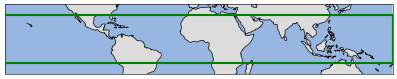

In [5]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [6]:
# Read a sample data
ds_tmp = xr.open_dataset(filenames['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [7]:
# xr.open_dataset(filenames['obs']).isel({'times':slice(0,duration_max), 'nmaxpf':0})
# ds = xr.open_mfdataset(list(filenames.values()), combine='nested', concat_dim='source').isel({'times':})

In [8]:
# Read all files and combine them with a new dimension 'source'
ds = xr.open_mfdataset(list(filenames.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds = ds.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds['source'] = list(name_map.keys())
ds

<xarray.Dataset>
Dimensions:                  (tracks: 5016, times: 80, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5012 5013 5014 5015
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5016), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [9]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 80])

In [10]:
ds.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

## Custom functions to subset tracks

In [11]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [12]:
dss = find_tracks_start(ds, load_data=False)

In [13]:
print(f'Number of MCS')
for key in dss['source'].data:
    ntracks = np.count_nonzero(dss.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS
OBS: 2514
OBSv7: 2527
ARPEGE: 772
IFS: 2406
MPAS: 1192
NICAM: 2769
SAM: 2631
UM: 1586
FV3: 2049
SCREAMv1: 2691


## Separate land vs. ocean MCS

In [14]:
dss_l, dss_o = get_land_ocean_ds(dss)

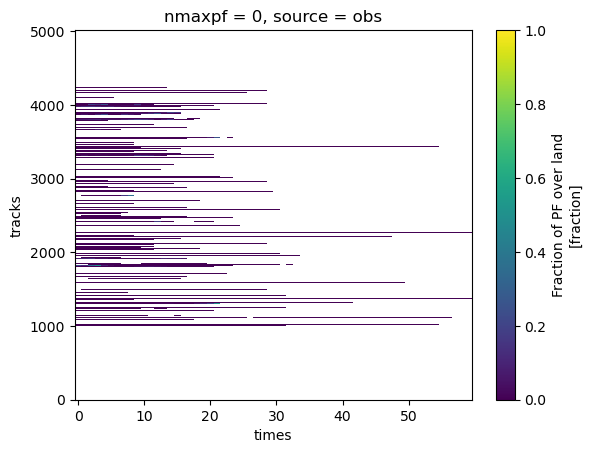

In [15]:
dss_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

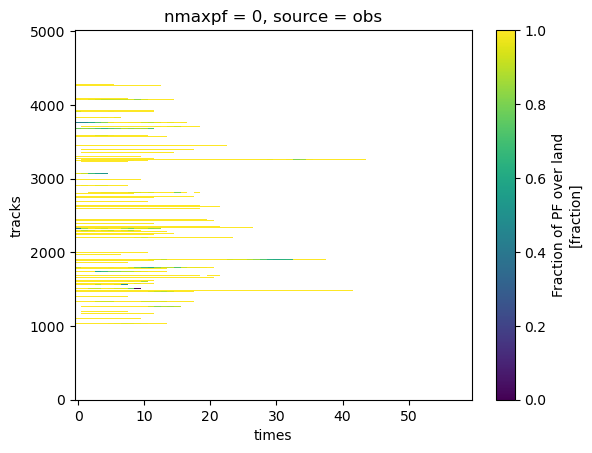

In [16]:
dss_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [17]:
# TODO: use a simple method to separate possible merge/split tracks
# E.g., if max CCS area occur within the first 10% of a tracks start time: split; or within last 10% of a tracks end time: merge
# ds.ccs_area.max(dim='times')

In [18]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

### CCS lifetime

In [19]:
da_tmp = (dss_l.track_duration * time_resolution).transpose()
ccslifetime_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.track_duration * time_resolution).transpose()
ccslifetime_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [20]:
ccslifetime_o

,OBS,OBSv7,ARPEGE,IFS,MPAS,NICAM,SAM,UM,FV3,SCREAMv1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
5012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
5013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


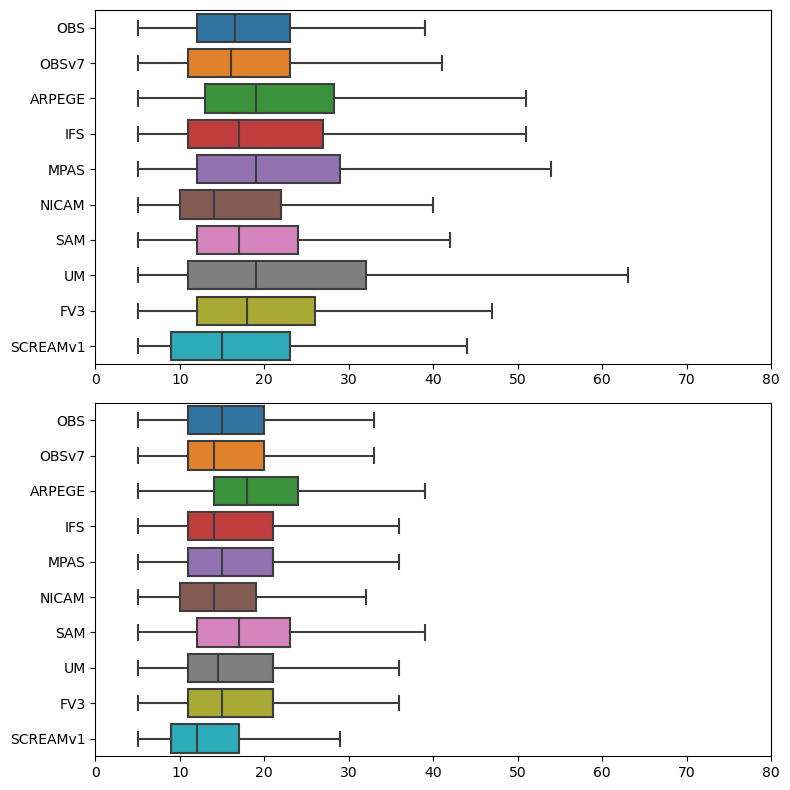

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=ccslifetime_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=ccslifetime_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(0,80)
fig.tight_layout()

### Max CCS area

In [22]:
da_tmp = (dss_l.ccs_area.max(dim='times')).transpose()
maxccsarea_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.ccs_area.max(dim='times')).transpose()
maxccsarea_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [23]:
# Convert to log10, and replace -inf with NaN
log10maxccsarea_o = np.log10(maxccsarea_o)
log10maxccsarea_l = np.log10(maxccsarea_l)
log10maxccsarea_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_l.replace(-np.inf, np.nan, inplace=True)

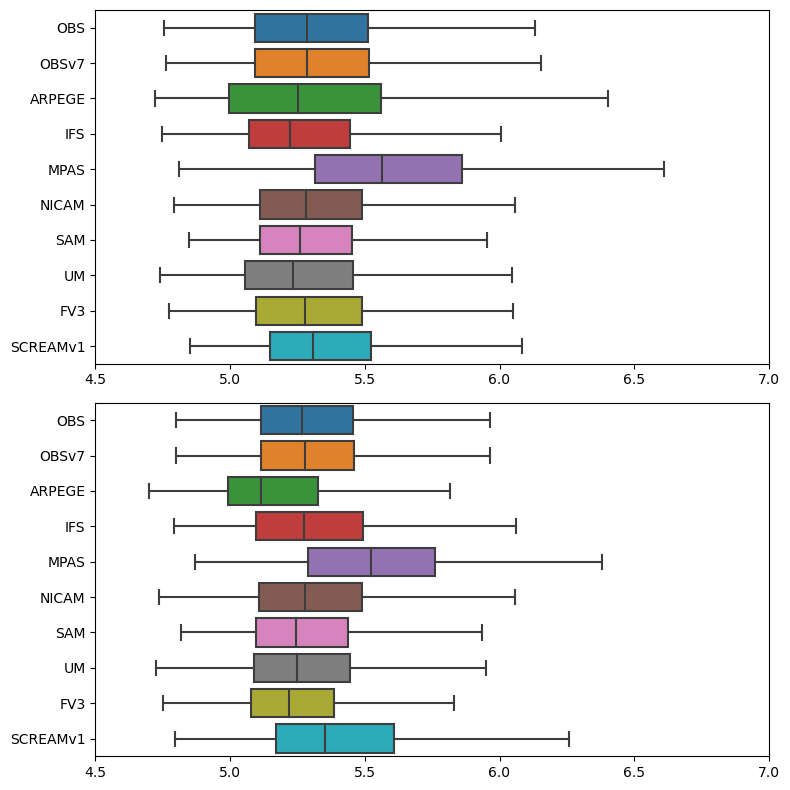

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=log10maxccsarea_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=log10maxccsarea_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(4.5,7)
fig.tight_layout()

### Lifetime-average min Tb

In [25]:
da_tmp = (dss_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

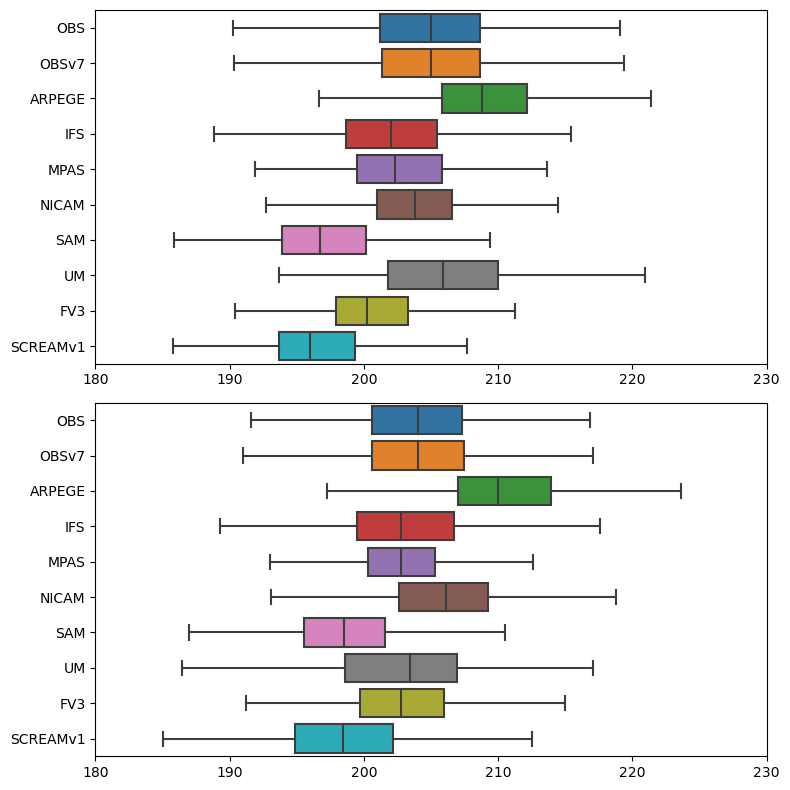

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=avgmintb_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=avgmintb_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(180,230)
fig.tight_layout()

### Total volume rain

In [27]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

da_tmp = (dss_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [28]:
# Convert to log10, and replace -inf with NaN
log10pfvolrain_o = np.log10(pfvolrain_o)
log10pfvolrain_l = np.log10(pfvolrain_l)
log10pfvolrain_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_l.replace(-np.inf, np.nan, inplace=True)

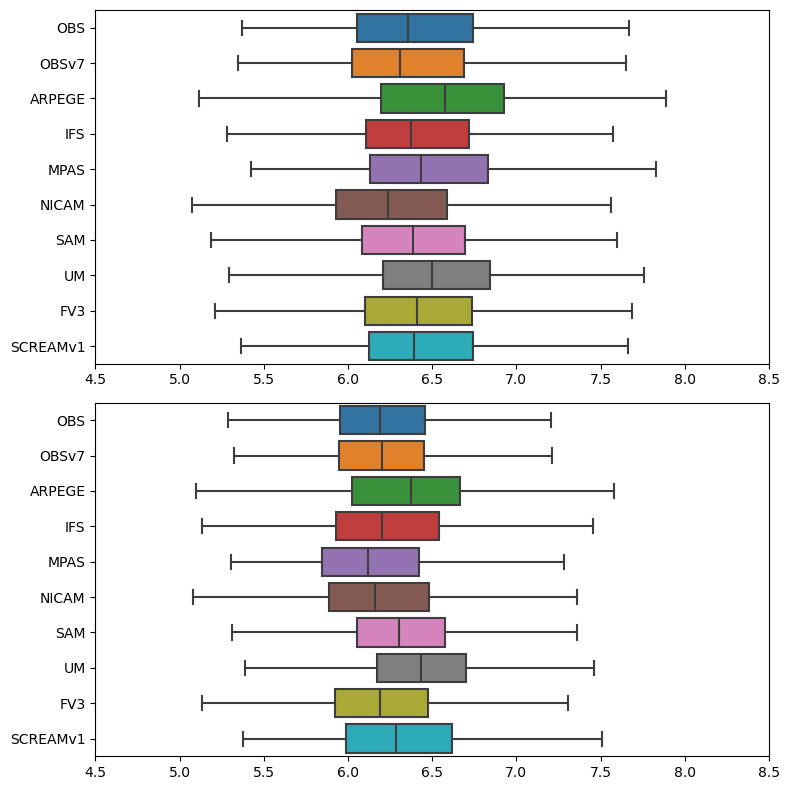

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=log10pfvolrain_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=log10pfvolrain_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(4.5,8.5)
fig.tight_layout()

### Heavy rain volume

In [30]:
da_tmp = (dss_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

### Heavy rain volume ratio

In [31]:
pfhrr_l = 100 * pfheavyvolrain_l / pfvolrain_l
pfhrr_o = 100 * pfheavyvolrain_o / pfvolrain_o

In [32]:
# Convert to log10, and replace -inf with NaN
log10pfhrr_o = np.log10(pfhrr_o)
log10pfhrr_l = np.log10(pfhrr_l)
pfhrr_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_o.replace(-np.inf, np.nan, inplace=True)

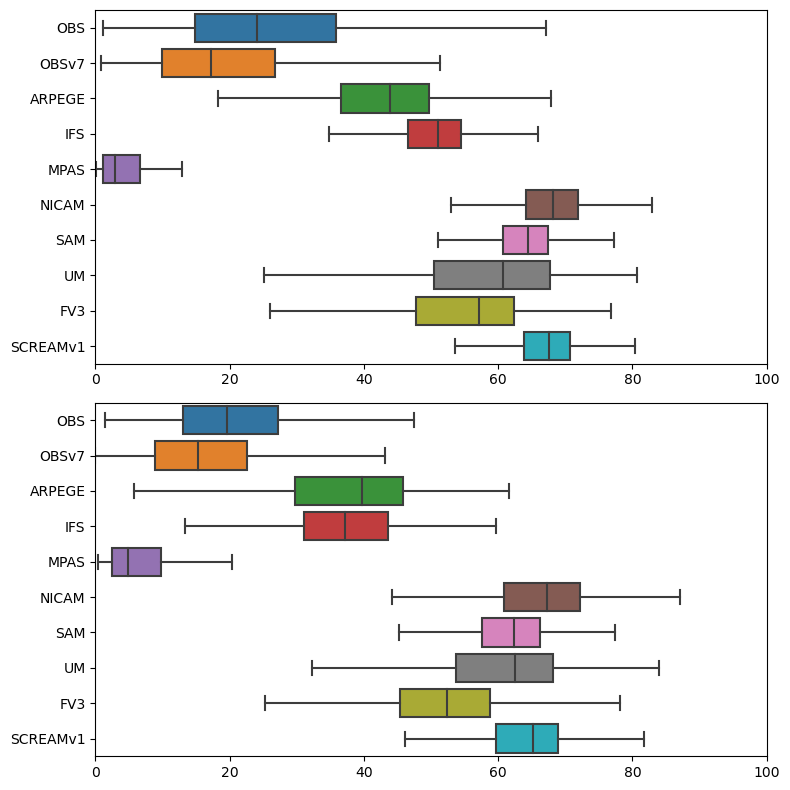

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=pfhrr_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=pfhrr_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(0,100)
fig.tight_layout()

### Mean PF rain rate

In [34]:
da_tmp = (dss_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

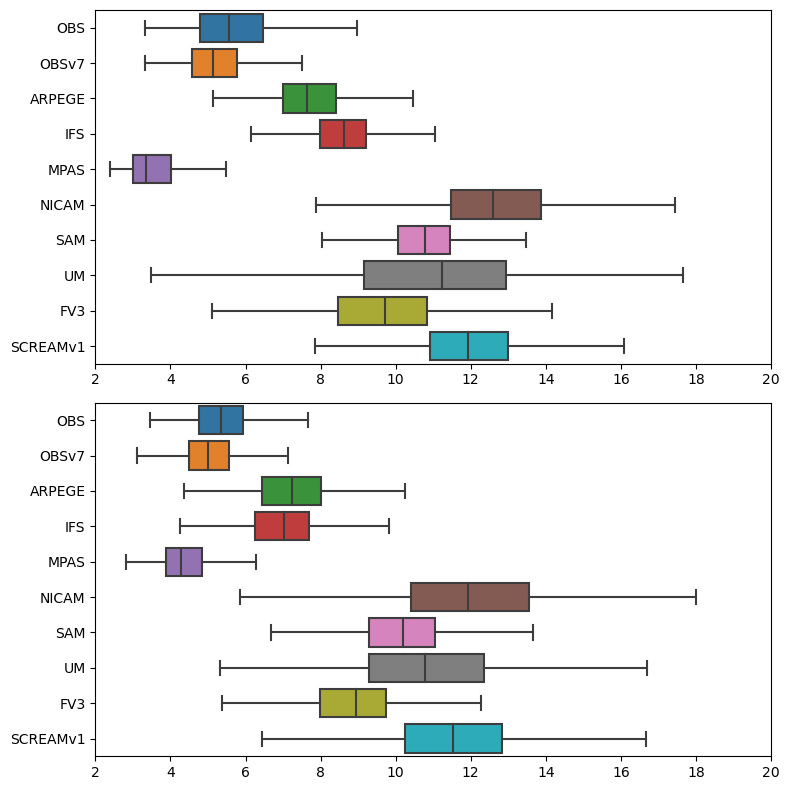

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
sns.boxplot(data=meanpfrainrate_o,  orient='h', ax=axes[0], showfliers=False)
sns.boxplot(data=meanpfrainrate_l,  orient='h', ax=axes[1], showfliers=False)

for row in range(2):
    axes[row].set_xlim(2,20)
fig.tight_layout()

In [36]:
ccslifetime_o.median()

OBS         16.5
OBSv7       16.0
ARPEGE      19.0
IFS         17.0
MPAS        19.0
NICAM       14.0
SAM         17.0
UM          19.0
FV3         18.0
SCREAMv1    15.0
dtype: float64

In [37]:
def get_diffs_percent(arrays):
    """
    Calculate relative difference between models & obs
    """
    nrow = len(arrays)
    ncol = len(arrays[0])-1
    # Make output array
    arr_out = np.full((nrow,ncol), np.NaN, dtype=float)
    for row in range(nrow):
        arr = arrays[row]
        arr_out[row,:] = 100 * (arr[1:] - arr['OBS']) / arr['OBS']
    return arr_out

In [38]:
list(name_map.values())[1:]

['OBSv7', 'ARPEGE', 'IFS', 'MPAS', 'NICAM', 'SAM', 'UM', 'FV3', 'SCREAMv1']

## Function to plot mirror box plot on (m x n) panels

In [39]:
def boxplot_mirror_mxn(nrow, ncol, data_top, data_bot, titles, xlabels, legends, figname,  
                        map_show=False, map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0], map_bottop='top', panel_colors=None,
                        wspace=None, hspace=None, label_pos=None,
                        legend_fontsize=11, legend_loc='best', label_topbot=None, legend_ncol=None, figsize=[10,10], fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=wspace, hspace=hspace)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=wspace, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=wspace, hspace=0)

    lcolors = {
        'obs': 'gray', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    # pcolors = list(lcolors.values())[:data_top[0][0].shape[1]]
    pcolors = [lcolors[key] for key in name_map.keys()]
    print(pcolors)
    notch = False

    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1)
        ax2.invert_yaxis()
        # ax1.xaxis.set_ticklabels([])
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(label_pos[0], label_pos[1], label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(label_pos[0], label_pos[1], label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            # ax1.legend(fontsize=legend_fontsize, loc=legend_loc, ncols=legend_ncol)


        # Plot inset map
        if (map_show):
            if (row == map_panel[0]) & (col == map_panel[1]):
                if map_bottop == 'top':
                    ax_map = ax1
                if map_bottop == 'bot':
                    ax_map = ax2
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax_map, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)
                
    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1)
        ax2.invert_yaxis()
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(label_pos[0], label_pos[1], label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(label_pos[0], label_pos[1], label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            
        fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

### Set up legends, inset map

In [40]:
# Inset map settings
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-180, 179, -35, 50], [-180, 179], [-15, 30])

## Ocean vs. Land

['gray', 'darkgray', 'crimson', 'darkorange', 'gold', 'green', 'turquoise', 'lime', 'blue', 'dodgerblue']


/tmp/ipykernel_1816061/407234754.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1816061/407234754.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1816061/407234754.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1816061/407234754.py:99: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

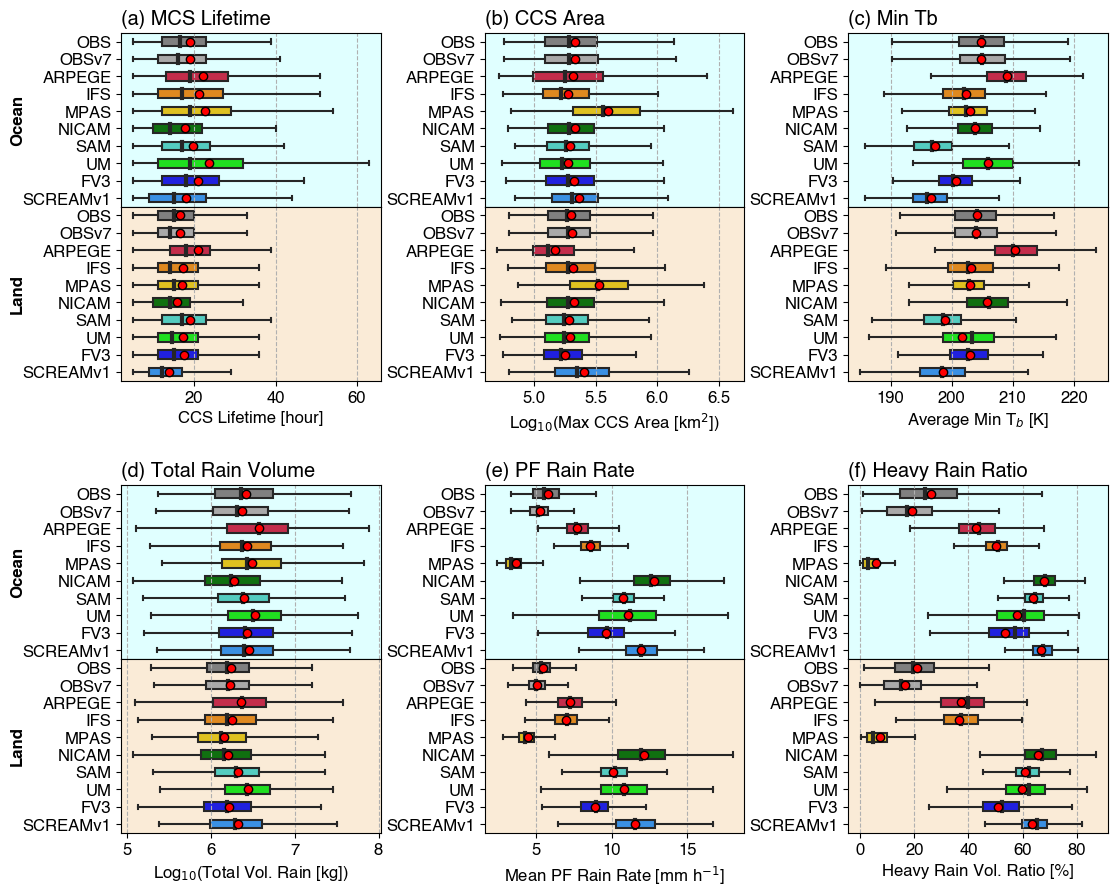

In [41]:
data_top = [
    [ccslifetime_o, log10maxccsarea_o, avgmintb_o, ],
    [log10pfvolrain_o, meanpfrainrate_o, pfhrr_o],
]
data_bot = [
    [ccslifetime_l, log10maxccsarea_l, avgmintb_l, ],
    [log10pfvolrain_l, meanpfrainrate_l, pfhrr_l],
]
titles = [
    ['(a) MCS Lifetime', '(b) CCS Area', '(c) Min Tb'],
    ['(d) Total Rain Volume', '(e) PF Rain Rate', '(f) Heavy Rain Ratio'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['Ocean', 'Land']
label_pos = (-0.4, 0.5)
panel_colors = {'top':'lightcyan', 'bot':'antiquewhite'}
legend_ncol = 2
figsize = (15,10)
fontsize = 12
wspace = 0.4
hspace = 0.3
figname = f'{figdir}boxwhisker_mcs_ocean_land_2x3_{tracker}.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                         wspace=wspace, hspace=hspace, label_pos=label_pos,
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)